In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/train_test_network.csv")
df.head()

,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,OTH,...,0,0,-,-,-,-,-,-,1,backdoor
1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000102,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
2,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000148,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
3,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000113,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
4,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000130,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor


In [ ]:
df.columns.to_list()

['src_ip',
 'src_port',
 'dst_ip',
 'dst_port',
 'proto',
 'service',
 'duration',
 'src_bytes',
 'dst_bytes',
 'conn_state',
 'missed_bytes',
 'src_pkts',
 'src_ip_bytes',
 'dst_pkts',
 'dst_ip_bytes',
 'dns_query',
 'dns_qclass',
 'dns_qtype',
 'dns_rcode',
 'dns_AA',
 'dns_RD',
 'dns_RA',
 'dns_rejected',
 'ssl_version',
 'ssl_cipher',
 'ssl_resumed',
 'ssl_established',
 'ssl_subject',
 'ssl_issuer',
 'http_trans_depth',
 'http_method',
 'http_uri',
 'http_version',
 'http_request_body_len',
 'http_response_body_len',
 'http_status_code',
 'http_user_agent',
 'http_orig_mime_types',
 'http_resp_mime_types',
 'weird_name',
 'weird_addl',
 'weird_notice',
 'label',
 'type']

In [ ]:
df.shape

(211043, 44)

In [ ]:
# Count number of rows where src_bytes is 0
num_zero_src_bytes = (df['src_bytes'] == 0).sum()
print("Number of rows with src_bytes == 0:", num_zero_src_bytes)
num_zero_dst_bytes = (df['dst_bytes'] == 0).sum()
print("Number of rows with dst_bytes == 0:", num_zero_dst_bytes)


Number of rows with src_bytes == 0: 138156
Number of rows with dst_bytes == 0: 148893


In [ ]:
df.loc[:, 'src_pkts'] = df['src_pkts'].replace(0, 1)
df.loc[:, 'dst_pkts'] = df['dst_pkts'].replace(0, 1)


# Compute Derived Features

In [ ]:
# 12 columns added new


# 1.Throughput & Packet Rates
df['bytes_per_sec'] = (df['src_bytes'] + df['dst_bytes']) / df['duration']
df['pkts_per_sec'] = (df['src_pkts'] + df['dst_pkts']) / df['duration']

# 2. Average Packet Sizes
df['avg_pkt_size_src'] = df['src_bytes'] / df['src_pkts'].replace(0, np.nan)
df['avg_pkt_size_dst'] = df['dst_bytes'] / df['dst_pkts'].replace(0, np.nan)

# 3 symmetry of Communication
eps = 1e-6
df['pkt_byte_asymmetry'] = abs(df['src_bytes'] - df['dst_bytes']) / (df['src_bytes'] + df['dst_bytes'] + eps)

# 4Connection Reliability (binary flag for abnormal states)
abnormal_states = ['OTH', 'RSTO', 'RSTR', 'S0', 'S1']  # Zeek states that indicate failures
df['failed_conn_flag'] = df['conn_state'].isin(abnormal_states).astype(int)

# 5 HTTP Error Rate (per flow)
df['http_error_flag'] = df['http_status_code'].apply(lambda x: 1 if pd.notna(x) and int(x) >= 400 else 0)

# 6 SSL Security Indicators
weak_ciphers = ['TLS_RSA_WITH_RC4_128_SHA', 'SSL_RSA_WITH_3DES_EDE_CBC_SHA']
df['unusual_cipher_flag'] = df['ssl_cipher'].isin(weak_ciphers).astype(int)

df['ssl_cert_mismatch_flag'] = np.where(
    (df['ssl_subject'].notna()) & (df['ssl_issuer'].notna()) &
    (df['ssl_subject'] != df['ssl_issuer']),
    1, 0
)


In [ ]:
num_zeros = (df['avg_pkt_size_dst'] == 0).sum()
print("Number of zero values:", num_zeros)


Number of zero values: 148893


Behavioral trust features that describe how an IoT node behaves at the network level.

In [ ]:
# 7 DNS Query Entropy (Shannon entropy for domain names)
def shannon_entropy(s):
    if not isinstance(s, str) or len(s) == 0:
        return 0
    prob = [float(s.count(c)) / len(s) for c in dict.fromkeys(s)]
    return -sum(p * np.log2(p) for p in prob)

df['dns_query_entropy'] = df['dns_query'].apply(shannon_entropy)

# 8 Node Degree (how many unique peers a src_ip contacts)
node_degree = df.groupby('src_ip')['dst_ip'].nunique().reset_index(name='node_degree')
df = df.merge(node_degree, on='src_ip', how='left')

# 9 Flow Rate (flows per source node)
flow_rate = df['src_ip'].value_counts().rename_axis('src_ip').reset_index(name='flow_rate')
df = df.merge(flow_rate, on='src_ip', how='left')

In [ ]:
print(flow_rate)

In [ ]:
print(node_degree)

In [ ]:
df.shape


(211043, 56)

In [ ]:
trust_features = df.groupby('src_ip').agg({
    'bytes_per_sec': 'mean',
    'pkts_per_sec': 'mean',
    'pkt_byte_asymmetry': 'mean',
    'failed_conn_flag': 'mean',
    'http_error_flag': 'mean',
    'unusual_cipher_flag': 'mean',
    'ssl_cert_mismatch_flag': 'mean',
    'dns_query_entropy': 'mean',
    'node_degree': 'mean',
    'flow_rate': 'mean'
}).reset_index()

# Example: Normalize values between 0–1
for col in trust_features.columns[1:]:
    trust_features[col] = (trust_features[col] - trust_features[col].min()) / (trust_features[col].max() - trust_features[col].min() + 1e-6)

In [ ]:
trust_features['pkts_per_sec'].fillna(0, inplace=True)


/tmp/ipython-input-2440160401.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trust_features['pkts_per_sec'].fillna(0, inplace=True)


In [ ]:
# Example weighting (you can tune or learn weights later)
weights = {
    'bytes_per_sec': 0.1,
    'pkts_per_sec': 0.1,
    'pkt_byte_asymmetry': -0.1,  # negative: more asymmetry = less trust
    'failed_conn_flag': -0.15,
    'http_error_flag': -0.1,
    'unusual_cipher_flag': -0.1,
    'ssl_cert_mismatch_flag': -0.1,
    'dns_query_entropy': -0.1,
    'node_degree': -0.1,  # high node_degree = possible scanning
    'flow_rate': 0.05
}

# Weighted trust score
trust_features['trust_score'] = trust_features.apply(
    lambda row: sum(row[col] * w for col, w in weights.items()), axis=1
)

# Normalize to 0–1 trust range
trust_features['trust_score'] = (trust_features['trust_score'] - trust_features['trust_score'].min()) / \
                                (trust_features['trust_score'].max() - trust_features['trust_score'].min() + 1e-6)

print(trust_features.head())


        src_ip  bytes_per_sec  pkts_per_sec  pkt_byte_asymmetry  \
0  13.55.50.68            NaN           0.0            0.000000   
1   172.17.0.5       0.029769           0.0            0.905249   
2   172.17.0.7       0.030491           0.0            0.925396   
3   172.17.0.8       0.042079           0.0            0.806800   
4  192.168.1.1       1.000000           0.0            0.917609   

   failed_conn_flag  http_error_flag  unusual_cipher_flag  \
0          0.999999              0.0                  0.0   
1          0.035766              0.0                  0.0   
2          0.012910              0.0                  0.0   
3          0.142710              0.0                  0.0   
4          0.983227              0.0                  0.0   

   ssl_cert_mismatch_flag  dns_query_entropy  node_degree  flow_rate  \
0                     0.0                0.0     0.000000   0.000097   
1                     0.0                0.0     0.000000   0.025328   
2             

In [ ]:
trust_features['trust_score'].fillna(0.5, inplace=True)


/tmp/ipython-input-4256591592.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trust_features['trust_score'].fillna(0.5, inplace=True)


In [ ]:
df.shape

(211043, 56)

In [ ]:
df.columns.to_list()

['src_ip',
 'src_port',
 'dst_ip',
 'dst_port',
 'proto',
 'duration',
 'src_bytes',
 'dst_bytes',
 'conn_state',
 'src_pkts',
 'dst_pkts',
 'dns_query',
 'ssl_cipher',
 'ssl_subject',
 'ssl_issuer',
 'http_status_code',
 'weird_name',
 'weird_addl',
 'weird_notice',
 'label',
 'type',
 'bytes_per_sec',
 'pkts_per_sec',
 'avg_pkt_size_src',
 'avg_pkt_size_dst',
 'pkt_byte_asymmetry',
 'failed_conn_flag',
 'http_error_flag',
 'unusual_cipher_flag',
 'ssl_cert_mismatch_flag']

Drop columns

In [ ]:

drop_cols = [
     'service'
    , 'missed_bytes', 'src_ip_bytes', 'dst_ip_bytes',
    'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected',
    'ssl_version','ssl_resumed', 'ssl_established',
    'http_trans_depth', 'http_method', 'http_uri', 'http_version', 'http_user_agent',
    'http_orig_mime_types', 'http_resp_mime_types', 'http_request_body_len', 'http_response_body_len'
]

df = df.drop(columns=drop_cols, errors='ignore')
print(df.columns)

Index(['src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'duration',
       'src_bytes', 'dst_bytes', 'conn_state', 'src_pkts', 'dst_pkts',
       'dns_query', 'ssl_cipher', 'ssl_subject', 'ssl_issuer',
       'http_status_code', 'weird_name', 'weird_addl', 'weird_notice', 'label',
       'type'],
      dtype='object')


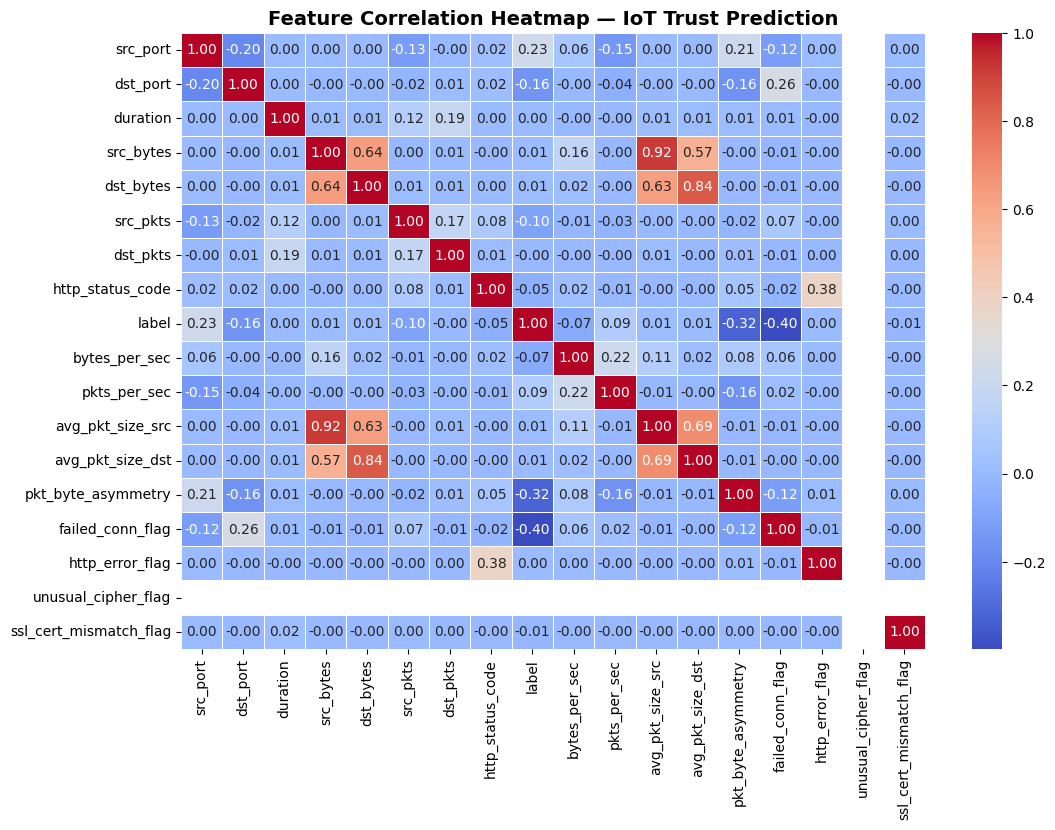

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

numeric_df = df.select_dtypes(include=['float64', 'int64'])

correlation = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap — IoT Trust Prediction", fontsize=14, fontweight='bold')
plt.show()


In [ ]:

df_cleaned.to_csv("iot_dataset_cleaned.csv", index=False)


# Final

In [130]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('/content/train_test_network.csv')
dataset.head()

,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,OTH,...,0,0,-,-,-,-,-,-,1,backdoor
1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000102,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
2,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000148,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
3,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000113,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
4,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000130,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor


1. Handling Missing values

In [131]:
dataset.columns

Index(['src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'service',
       'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes',
       'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_query',
       'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA',
       'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed',
       'ssl_established', 'ssl_subject', 'ssl_issuer', 'http_trans_depth',
       'http_method', 'http_uri', 'http_version', 'http_request_body_len',
       'http_response_body_len', 'http_status_code', 'http_user_agent',
       'http_orig_mime_types', 'http_resp_mime_types', 'weird_name',
       'weird_addl', 'weird_notice', 'label', 'type'],
      dtype='object')

In [132]:
dataset.isnull().sum()

,0
src_ip,0
src_port,0
dst_ip,0
dst_port,0
proto,0
service,0
duration,0
src_bytes,0
dst_bytes,0
conn_state,0


We have zero missing or null values

In [133]:
dataset.dtypes

,0
src_ip,object
src_port,int64
dst_ip,object
dst_port,int64
proto,object
service,object
duration,float64
src_bytes,int64
dst_bytes,int64
conn_state,object


In [134]:
dataset.shape

(211043, 44)

Drop non usable or values of columns not included cols
Unwanted columns



In [135]:
drop_cols = [
     'service'
    , 'missed_bytes', 'src_ip_bytes', 'dst_ip_bytes',
    'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected',
    'ssl_version','ssl_resumed', 'ssl_established',
    'http_trans_depth', 'http_method', 'http_uri', 'http_version', 'http_user_agent',
    'http_orig_mime_types', 'http_resp_mime_types', 'http_request_body_len', 'http_response_body_len'
]
dataset = dataset.drop(columns=drop_cols, errors='ignore')
print(dataset.columns)

categorical_cols = dataset.select_dtypes(include='object').columns
numerical_cols = dataset.select_dtypes(include=['int64', 'float64']).columns

Index(['src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'duration',
       'src_bytes', 'dst_bytes', 'conn_state', 'src_pkts', 'dst_pkts',
       'dns_query', 'ssl_cipher', 'ssl_subject', 'ssl_issuer',
       'http_status_code', 'weird_name', 'weird_addl', 'weird_notice', 'label',
       'type'],
      dtype='object')


In [136]:
dataset.columns


Index(['src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'duration',
       'src_bytes', 'dst_bytes', 'conn_state', 'src_pkts', 'dst_pkts',
       'dns_query', 'ssl_cipher', 'ssl_subject', 'ssl_issuer',
       'http_status_code', 'weird_name', 'weird_addl', 'weird_notice', 'label',
       'type'],
      dtype='object')

In [137]:
dataset.shape

(211043, 21)

Seperating categorical and numerical cols

In [138]:
categorical_cols = dataset.select_dtypes(include='object').columns
numerical_cols = dataset.select_dtypes(include=['int64', 'float64']).columns

In [139]:
categorical_cols

Index(['src_ip', 'dst_ip', 'proto', 'conn_state', 'dns_query', 'ssl_cipher',
       'ssl_subject', 'ssl_issuer', 'weird_name', 'weird_addl', 'weird_notice',
       'type'],
      dtype='object')

In [140]:
numerical_cols

Index(['src_port', 'dst_port', 'duration', 'src_bytes', 'dst_bytes',
       'src_pkts', 'dst_pkts', 'http_status_code', 'label'],
      dtype='object')

In [141]:
dataset[categorical_cols].head()

,src_ip,dst_ip,proto,conn_state,dns_query,ssl_cipher,ssl_subject,ssl_issuer,weird_name,weird_addl,weird_notice,type
0,192.168.1.37,192.168.1.193,tcp,OTH,-,-,-,-,-,-,-,backdoor
1,192.168.1.193,192.168.1.37,tcp,REJ,-,-,-,-,-,-,-,backdoor
2,192.168.1.193,192.168.1.37,tcp,REJ,-,-,-,-,-,-,-,backdoor
3,192.168.1.193,192.168.1.37,tcp,REJ,-,-,-,-,-,-,-,backdoor
4,192.168.1.193,192.168.1.37,tcp,REJ,-,-,-,-,-,-,-,backdoor


In [143]:
dataset.columns

Index(['src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'duration',
       'src_bytes', 'dst_bytes', 'conn_state', 'src_pkts', 'dst_pkts',
       'dns_query', 'ssl_cipher', 'ssl_subject', 'ssl_issuer',
       'http_status_code', 'weird_name', 'weird_addl', 'weird_notice', 'label',
       'type'],
      dtype='object')

In [144]:
dataset[categorical_cols].describe()

,src_ip,dst_ip,proto,conn_state,dns_query,ssl_cipher,ssl_subject,ssl_issuer,weird_name,weird_addl,weird_notice,type
count,211043,211043,211043,211043,211043,211043,211043,211043,211043,211043,211043,211043
unique,51,753,3,13,726,6,6,5,11,3,2,10
top,192.168.1.30,192.168.1.190,tcp,S0,-,-,-,-,-,-,-,normal
freq,61633,47795,168747,51937,176198,210642,211032,211032,210687,210886,210687,50000


In [145]:
dataset[numerical_cols].head()

,src_port,dst_port,duration,src_bytes,dst_bytes,src_pkts,dst_pkts,http_status_code,label
0,4444,49178,290.371539,101568,2592,108,31,0,1
1,49180,8080,0.000102,0,0,1,1,0,1
2,49180,8080,0.000148,0,0,1,1,0,1
3,49180,8080,0.000113,0,0,1,1,0,1
4,49180,8080,0.000130,0,0,1,1,0,1


Scaling Normalization

In [146]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dataset[numerical_cols] = scaler.fit_transform(dataset[numerical_cols])

In [147]:
dataset[numerical_cols].head()

,src_port,dst_port,duration,src_bytes,dst_bytes,src_pkts,dst_pkts,http_status_code,label
0,-1.771488,4.482402,0.501064,-0.009157,-0.014214,1.072197,0.082107,-0.036746,0.557204
1,0.545572,0.449865,-0.013650,-0.015099,-0.014358,-0.093652,-0.008608,-0.036746,0.557204
2,0.545572,0.449865,-0.013650,-0.015099,-0.014358,-0.093652,-0.008608,-0.036746,0.557204
3,0.545572,0.449865,-0.013650,-0.015099,-0.014358,-0.093652,-0.008608,-0.036746,0.557204
4,0.545572,0.449865,-0.013650,-0.015099,-0.014358,-0.093652,-0.008608,-0.036746,0.557204


Encoding categorical

In [148]:
unique_proto = dataset['proto'].unique()
unique_conn_state = dataset['conn_state'].unique()
unique_type = dataset['type'].unique()

print("Unique values in 'proto':", unique_proto)
print("Unique values in 'conn_state':", unique_conn_state)
print("Unique values in 'type':", unique_type)

Unique values in 'proto': ['tcp' 'udp' 'icmp']
Unique values in 'conn_state': ['OTH' 'REJ' 'S1' 'RSTR' 'SF' 'RSTO' 'SH' 'S3' 'S0' 'SHR' 'S2' 'RSTOS0'
 'RSTRH']
Unique values in 'type': ['backdoor' 'ddos' 'dos' 'injection' 'mitm' 'normal' 'password'
 'ransomware' 'scanning' 'xss']


In [149]:
dataset.columns

Index(['src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'duration',
       'src_bytes', 'dst_bytes', 'conn_state', 'src_pkts', 'dst_pkts',
       'dns_query', 'ssl_cipher', 'ssl_subject', 'ssl_issuer',
       'http_status_code', 'weird_name', 'weird_addl', 'weird_notice', 'label',
       'type'],
      dtype='object')

In [150]:
import pandas as pd

unique_classes = dataset['dns_query'].unique()
print(unique_classes)

value_counts = dataset['dns_query'].value_counts()
print(value_counts)


['-' 'mqtt-dashboard-lb-1160139393.eu-central-1.elb.amazonaws.com'
 'https://192.168.1.184' 'detectportal.firefox.com'
 'https://192.168.1.184.hub' 'home_url=192.168.1.190.hub'
 'home_url=192.168.1.190' 'jigsaw.w3.org' 'downforeveryoneorjustme.com'
 'status.ws' 'http://192.168.1.190.hub' 'http://192.168.1.190'
 'http://192.168.1.194' 'http://192.168.1.194.hub'
 'testphp.vulnweb.com/listproducts.php.hub' 'testphp.vulnweb.com'
 'testphp.vulnweb.com/listproducts.php' '192.168.1.195/dvwa/login.php-r'
 '192.168.1.195/dvwa/login.php-r.hub'
 'http://192.168.1.195/dvwa/login.php-r'
 'http://192.168.1.195/dvwa/login.php-r.hub' 'broker.hivemq.com'
 'http://192.168.1.152.hub' 'http://192.168.1.152'
 'http://testphp.vulnweb.com/listproducts.php'
 'http://testphp.vulnweb.com/listproducts.php.hub' 'wpad' 'wpad.hub'
 'tiles.services.mozilla.com' 'ocsp.digicert.com'
 'tiles-cloudfront.cdn.mozilla.net' 'safebrowsing.google.com'
 'self-repair.mozilla.org' 'ocsp.pki.goog' 'adservice.google.com'
 'c.evido

In [151]:
for col in categorical_cols:
    print(f"Unique values in '{col}':")
    print(dataset[col].unique())
    print("\n")

Unique values in 'src_ip':
['192.168.1.37' '192.168.1.193' '192.168.1.33' '192.168.1.30'
 '192.168.1.31' '192.168.1.38' '192.168.1.34' '192.168.1.39'
 '192.168.1.190' '220.158.215.20' '192.168.1.152' '192.168.1.169'
 '192.168.1.195' '192.168.1.1' '192.168.1.79' '192.168.1.250'
 '192.168.1.133' '192.168.1.192' '192.168.1.103' '192.168.1.46'
 '192.168.1.194' '192.168.1.17' '192.168.1.191'
 '2405:6e00:10ce:2c00:20c:29ff:feee:e07a' 'fe80::8520:4eba:6770:702a'
 'fe80::855:e4ef:de26:7aca' 'fe80::1087:c341:7263:ead3'
 'fe80::601f:9cde:4832:2f3f' 'fe80::f554:8774:9968:b60b'
 'fe80::343b:2cf:e9fb:6570' '2405:6e00:10ce:2c00:9064:17:85d2:57d4'
 '2405:6e00:10ce:2c00:c058:dbaa:f212:a2d8'
 '2405:6e00:10ce:2c00:20c:29ff:fed2:b002' '192.168.1.6'
 'fe80::ee1f:72ff:fef1:286d' 'fe80::76:ad3e:1329:a7fd'
 'fe80::e4a6:b91f:48f3:ac01' '2405:6e00:10ce:2c00:8520:4eba:6770:702a'
 '172.17.0.8' '172.17.0.5' '192.168.1.180' '172.17.0.7' '192.168.1.186'
 '192.168.1.49' '199.115.158.193' 'fe80::ffff:ffff:ffff' '192.

One-hot encode small-cardinality categorical features (proto, conn_state, label, type).

Label encode large-cardinality features (src_ip, dst_ip, service, http_user_agent) to avoid exploding the feature space.



In [152]:
dataset[categorical_cols]

,src_ip,dst_ip,proto,conn_state,dns_query,ssl_cipher,ssl_subject,ssl_issuer,weird_name,weird_addl,weird_notice,type
0,192.168.1.37,192.168.1.193,tcp,OTH,-,-,-,-,-,-,-,backdoor
1,192.168.1.193,192.168.1.37,tcp,REJ,-,-,-,-,-,-,-,backdoor
2,192.168.1.193,192.168.1.37,tcp,REJ,-,-,-,-,-,-,-,backdoor
3,192.168.1.193,192.168.1.37,tcp,REJ,-,-,-,-,-,-,-,backdoor
4,192.168.1.193,192.168.1.37,tcp,REJ,-,-,-,-,-,-,-,backdoor
...,...,...,...,...,...,...,...,...,...,...,...,...
211038,192.168.1.32,176.28.50.165,tcp,S3,-,-,-,-,-,-,-,xss
211039,192.168.1.32,176.28.50.165,tcp,S3,-,-,-,-,-,-,-,xss
211040,192.168.1.32,176.28.50.165,tcp,S3,-,-,-,-,-,-,-,xss
211041,192.168.1.32,176.28.50.165,tcp,S3,-,-,-,-,-,-,-,xss


In [153]:
dataset.columns

Index(['src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'duration',
       'src_bytes', 'dst_bytes', 'conn_state', 'src_pkts', 'dst_pkts',
       'dns_query', 'ssl_cipher', 'ssl_subject', 'ssl_issuer',
       'http_status_code', 'weird_name', 'weird_addl', 'weird_notice', 'label',
       'type'],
      dtype='object')

In [155]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Step 3: Small-cardinality categorical features → one-hot encode
small_cat_features = ['proto', 'conn_state', 'type']
ohe = OneHotEncoder(drop='first')
encoded_features = ohe.fit_transform(dataset[small_cat_features]).toarray()

# Convert encoded features back to DataFrame and concatenate with original dataset
encoded_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(small_cat_features), index=dataset_new.index)
dataset = pd.concat([dataset.drop(columns=small_cat_features), encoded_df], axis=1)


# Step 4: Large-cardinality categorical features → label encode
large_cat_features = ['src_ip', 'dst_ip', 'dns_query', 'ssl_cipher', 'ssl_subject', 'ssl_issuer', 'weird_name', 'weird_addl', 'weird_notice']
le = LabelEncoder()
for col in large_cat_features:
    # Handle potential missing values before encoding
    dataset[col] = dataset[col].astype(str)
    dataset[col] = le.fit_transform(dataset[col])

In [157]:
dataset.columns

Index(['src_ip', 'src_port', 'dst_ip', 'dst_port', 'duration', 'src_bytes',
       'dst_bytes', 'src_pkts', 'dst_pkts', 'dns_query', 'ssl_cipher',
       'ssl_subject', 'ssl_issuer', 'http_status_code', 'weird_name',
       'weird_addl', 'weird_notice', 'label', 'proto_tcp', 'proto_udp',
       'conn_state_REJ', 'conn_state_RSTO', 'conn_state_RSTOS0',
       'conn_state_RSTR', 'conn_state_RSTRH', 'conn_state_S0', 'conn_state_S1',
       'conn_state_S2', 'conn_state_S3', 'conn_state_SF', 'conn_state_SH',
       'conn_state_SHR', 'type_ddos', 'type_dos', 'type_injection',
       'type_mitm', 'type_normal', 'type_password', 'type_ransomware',
       'type_scanning', 'type_xss'],
      dtype='object')